# import libraries

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from lightgbm import LGBMClassifier, plot_importance, plot_tree
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

# Read the data

In [2]:
data = pd.read_csv('Loan.csv')

In [3]:
data.head()

ApplicationDate  Age  AnnualIncome  CreditScore EmploymentStatus  \
0      2018-01-01   45         39948          617         Employed   
1      2018-01-02   38         39709          628         Employed   
2      2018-01-03   47         40724          570         Employed   
3      2018-01-04   58         69084          545         Employed   
4      2018-01-05   37        103264          594         Employed   

  EducationLevel  Experience  LoanAmount  LoanDuration MaritalStatus  ...  \
0         Master          22       13152            48       Married  ...   
1      Associate          15       26045            48        Single  ...   
2       Bachelor          26       17627            36       Married  ...   
3    High School          34       37898            96        Single  ...   
4      Associate          17        9184            36       Married  ...   

   MonthlyIncome UtilityBillsPaymentHistory  JobTenure  NetWorth  \
0    3329.000000                   0.724972         11    126928   
1    3309.083333                   0.935132          3     43609   
2    3393.666667                   0.872241          6      5205   
3    5757.000000                   0.896155          5     99452   
4    8605.333333                   0.941369          5    227019   

   BaseInterestRate  InterestRate  MonthlyLoanPayment  TotalDebtToIncomeRatio  \
0          0.199652      0.227590          419.805992                0.181077   
1          0.207045      0.201077          794.054238                0.389852   
2          0.217627      0.212548          666.406688                0.462157   
3          0.300398      0.300911         1047.506980                0.313098   
4          0.197184      0.175990          330.179140                0.070210   

  LoanApproved  RiskScore  
0            0       49.0  
1            0       52.0  
2            0       52.0  
3            0       54.0  
4            1       36.0  

[5 rows x 36 columns]

In [4]:
data.shape

(20000, 36)

In [5]:
data.drop(columns=['ApplicationDate', 'RiskScore'], inplace=True)

In [6]:
data.shape

(20000, 34)

## Data Preprocessing

In [7]:
numerical_features = [
    'Age', 
    'AnnualIncome', 
    'CreditScore',
    'Experience',
    'LoanAmount',
    'LoanDuration',
    'NumberOfDependents',
    'MonthlyDebtPayments',
    'CreditCardUtilizationRate',
    'NumberOfOpenCreditLines',
    'NumberOfCreditInquiries',
    'DebtToIncomeRatio',
    'BankruptcyHistory',
    'PreviousLoanDefaults',
    'PaymentHistory',
    'LengthOfCreditHistory',
    'SavingsAccountBalance',
    'CheckingAccountBalance',
    'TotalAssets',
    'TotalLiabilities',
    'MonthlyIncome',
    'UtilityBillsPaymentHistory',
    'JobTenure',
    'NetWorth',
    'BaseInterestRate',
    'InterestRate',
    'MonthlyLoanPayment',
    'TotalDebtToIncomeRatio'
]
print(f'Number of numerical features: {len(numerical_features)}')

Number of numerical features: 28


In [8]:
categorical_features = [
    'EmploymentStatus',
    'MaritalStatus',
    'HomeOwnershipStatus',
    'LoanPurpose'
]
print(f'Number of categorical features: {len(categorical_features)}')

Number of categorical features: 4


In [9]:
ordinal_features = [
    'EducationLevel'
]

print(f'Number of ordinal features: {len(ordinal_features)}')

Number of ordinal features: 1


In [10]:
X = data.drop(columns='LoanApproved')
y = data['LoanApproved']

In [11]:
X.head()

Age  AnnualIncome  CreditScore EmploymentStatus EducationLevel  Experience  \
0   45         39948          617         Employed         Master          22   
1   38         39709          628         Employed      Associate          15   
2   47         40724          570         Employed       Bachelor          26   
3   58         69084          545         Employed    High School          34   
4   37        103264          594         Employed      Associate          17   

   LoanAmount  LoanDuration MaritalStatus  NumberOfDependents  ...  \
0       13152            48       Married                   2  ...   
1       26045            48        Single                   1  ...   
2       17627            36       Married                   2  ...   
3       37898            96        Single                   1  ...   
4        9184            36       Married                   1  ...   

  TotalAssets  TotalLiabilities  MonthlyIncome  UtilityBillsPaymentHistory  \
0      146111             19183    3329.000000                    0.724972   
1       53204              9595    3309.083333                    0.935132   
2       25176            128874    3393.666667                    0.872241   
3      104822              5370    5757.000000                    0.896155   
4      244305             17286    8605.333333                    0.941369   

   JobTenure  NetWorth  BaseInterestRate InterestRate  MonthlyLoanPayment  \
0         11    126928          0.199652     0.227590          419.805992   
1          3     43609          0.207045     0.201077          794.054238   
2          6      5205          0.217627     0.212548          666.406688   
3          5     99452          0.300398     0.300911         1047.506980   
4          5    227019          0.197184     0.175990          330.179140   

   TotalDebtToIncomeRatio  
0                0.181077  
1                0.389852  
2                0.462157  
3                0.313098  
4                0.070210  

[5 rows x 33 columns]

In [12]:
X.shape

(20000, 33)

In [13]:
y.shape

(20000,)

In [14]:
def remove_highly_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > threshold)]
    return df.drop(columns=to_drop), to_drop

In [15]:
X_numerical, dropped_features = remove_highly_correlated_features(X[numerical_features])
print(f"Dropped highly correlated features: {dropped_features}")

Dropped highly correlated features: ['Experience', 'MonthlyIncome', 'NetWorth']


In [16]:
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

oridnal_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder())
])

In [17]:
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, X_numerical.columns),
    ('cat', categorical_pipeline, categorical_features),
    ('ord', oridnal_pipeline, ordinal_features)
])

In [18]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [19]:
X_dev

Age  AnnualIncome  CreditScore EmploymentStatus EducationLevel  \
15234   50         34402          504         Employed    High School   
15766   39         51561          612         Employed    High School   
16912   23        119497          440         Employed    High School   
12481   38         28425          616         Employed      Associate   
1572    43         55821          596         Employed         Master   
...    ...           ...          ...              ...            ...   
9711    48         84127          609    Self-Employed       Bachelor   
16422   21         35506          506         Employed    High School   
6528    40        112359          587       Unemployed       Bachelor   
10125   38         40653          560         Employed       Bachelor   
19666   58         31069          583         Employed      Associate   

       Experience  LoanAmount  LoanDuration MaritalStatus  NumberOfDependents  \
15234          27       16368            36        Single                   3   
15766          15       24926            84       Married                   0   
16912           0       28380            96      Divorced                   3   
12481          16        9736            72       Married                   0   
1572           23       33557            48       Married                   0   
...           ...         ...           ...           ...                 ...   
9711           29       17138            72        Single                   0   
16422           0       45792            12        Single                   0   
6528           17       16731            48       Married                   2   
10125          15       17285           120        Single                   1   
19666          36       30596            60        Single                   3   

       ... TotalAssets  TotalLiabilities  MonthlyIncome  \
15234  ...       72186             17083    2866.833333   
15766  ...      109968             77770    4296.750000   
16912  ...      196736             16656    9958.083333   
12481  ...       65039            107402    2368.750000   
1572   ...       29112             25916    4651.750000   
...    ...         ...               ...            ...   
9711   ...       25443            182538    7010.583333   
16422  ...       84136             76525    2958.833333   
6528   ...      100017             17807    9363.250000   
10125  ...       33086             33109    3387.750000   
19666  ...       12577             46174    2589.083333   

       UtilityBillsPaymentHistory  JobTenure  NetWorth  BaseInterestRate  \
15234                    0.773278          6     55103          0.249368   
15766                    0.630414          6     32198          0.243926   
16912                    0.682065          5    180080          0.343380   
12481                    0.903981          8     10354          0.216736   
1572                     0.757372          2      3196          0.230557   
...                           ...        ...       ...               ...   
9711                     0.908477          4      2872          0.227638   
16422                    0.843921          5      7611          0.257792   
6528                     0.873692          3     82210          0.218231   
10125                    0.866658          5      4215          0.292285   
19666                    0.932121          7      5680          0.244096   

      InterestRate  MonthlyLoanPayment  TotalDebtToIncomeRatio  
15234     0.258136          657.852731                0.302722  
15766     0.257986          643.701402                0.295968  
16912     0.320933          824.436576                0.112515  
12481     0.236320          254.147489                0.229297  
1572      0.242008         1097.749030                0.330144  
...            ...                 ...                     ...  
9711      0.214156          424.686853                0.163993  
16422     0.263

## Fitting the Classifier using GridSearch Cross Validation

In [20]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42))
])

In [21]:
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__num_leaves': [15, 31, 63]
}

In [22]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

In [23]:
grid_search.fit(X_dev, y_dev)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Info] Number of positive: 3059, number of negative: 9741
[LightGBM] [Info] Number of positive: 3059, number of negative: 9741
[LightGBM] [Info] Number of positive: 3060, number of negative: 9740
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4019
[LightGBM] [Info] Number of data points in the train set: 12800, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238984 -> initscore=-1.158256
[LightGBM] [Info] Start training from score -1.158256
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4019
[LightGBM] [Warning] No further splits with posi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration',
       'NumberOfDependents', 'MonthlyDebtPayments',
       'CreditCardUtilizationRate', 'NumberOfOpenCreditLines',
       'NumberOfCreditInquiries', 'DebtToIncom...
                                                                          'HomeOwnershipStatus',
                                                                          'LoanPurpose']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ordinal',
                                                                                          OrdinalEncoder())]),
                                                                         ['EducationLevel'])])),
                                       ('classifier',
                                        LGBMClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [50, 100, 150],
                         'classifier__num_leaves': [15, 31, 63]},
             scoring='accuracy', verbose=2)

In [24]:
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.2f}")

Best Parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 150, 'classifier__num_leaves': 15}
Best Cross-Validation Accuracy: 0.95


## Evaluation

In [25]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [26]:
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred))


Test Set Performance:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3044
           1       0.93      0.92      0.92       956

    accuracy                           0.96      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.96      0.96      0.96      4000



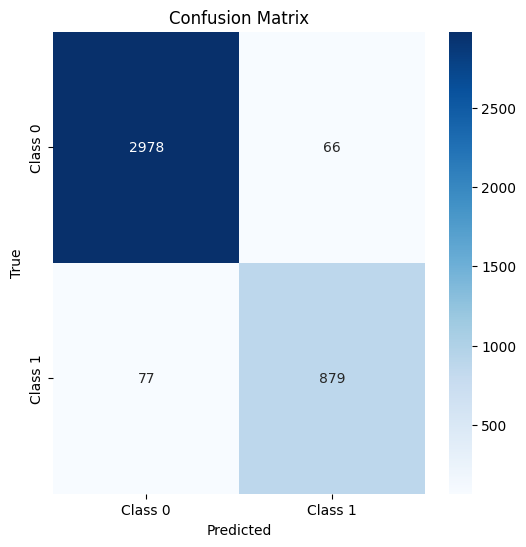

In [45]:
y_pred = best_model.predict(X_test) 
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

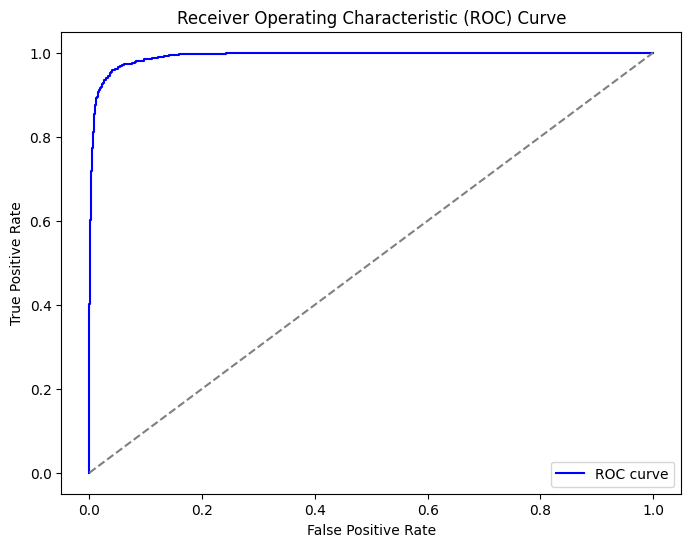

In [46]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [47]:
auroc = roc_auc_score(y_test, y_pred_proba)
print(f"AUROC: {auroc}")

AUROC: 0.9924977594994474


## Model Interpretability

In [27]:
def get_feature_names():
    transformed_feature_names = []
    transformed_feature_names.extend(X_numerical.columns)
    preprocessor = best_model.named_steps['preprocessor']

    categorical_features = preprocessor.transformers_[1][2]  # Categorical features list
    cat_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
    transformed_feature_names.extend(cat_feature_names)

    ordinal_features = preprocessor.transformers_[2][2]  # Ordinal features list
    transformed_feature_names.extend(ordinal_features)
    return transformed_feature_names

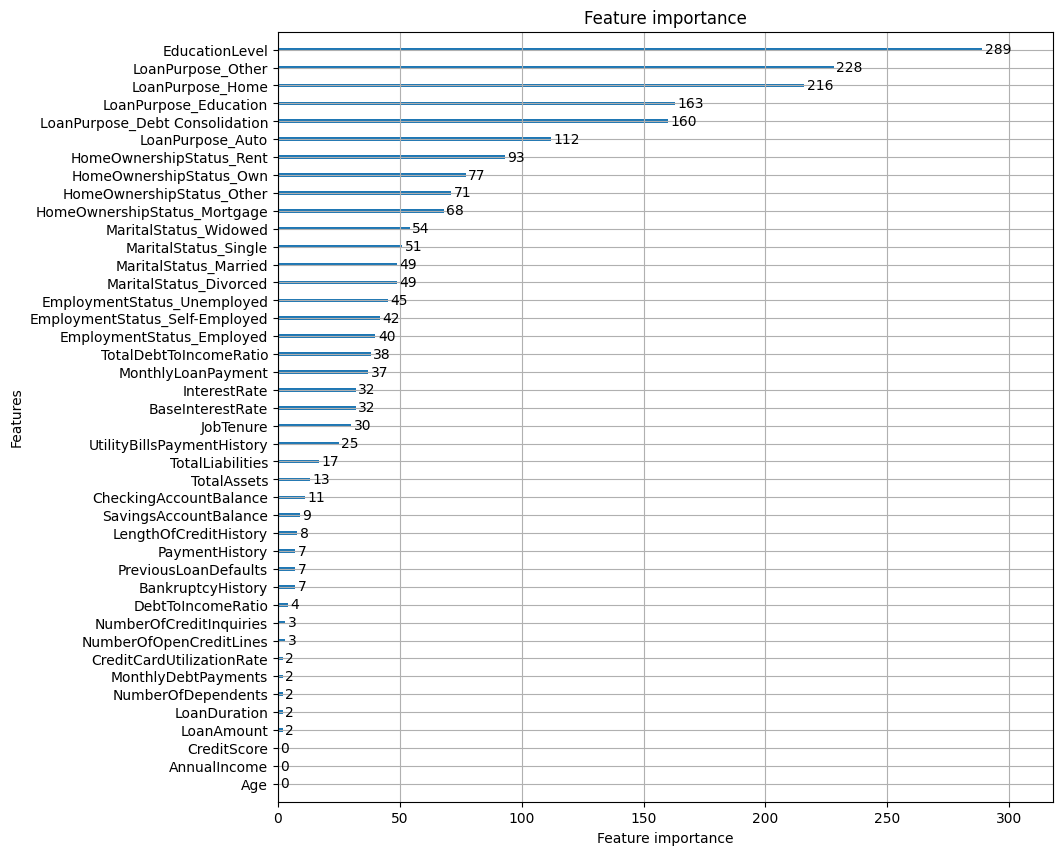

In [33]:
model = best_model.named_steps['classifier']

ax = plot_importance(model, ignore_zero=False, figsize=(10, 10))
ax.set_yticklabels(get_feature_names())
plt.show()

PermutationExplainer explainer: 4001it [02:04, 29.90it/s]                          


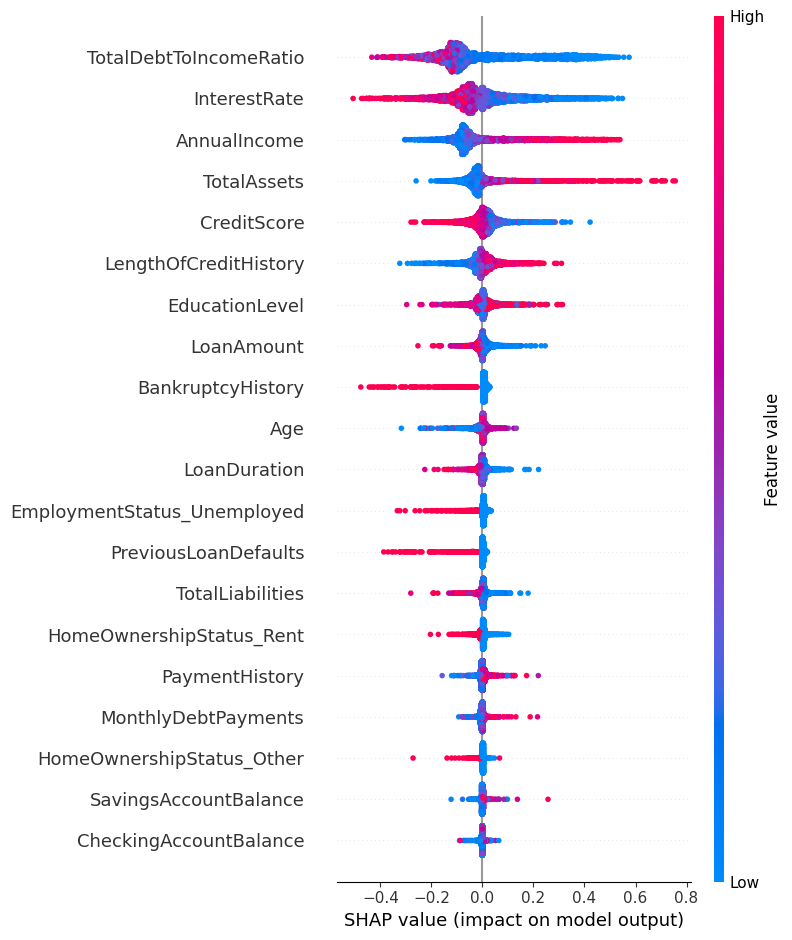

In [ ]:
# Apply the preprocessor transformation to X_dev and X_test to ensure numerical format
X_dev_transformed = best_model.named_steps['preprocessor'].transform(X_dev)
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

# Create the explainer using the AdaBoostClassifier's prediction function
explainer = shap.Explainer(model.predict, X_dev_transformed)

# Calculate SHAP values for the transformed test set
shap_values = explainer(X_test_transformed)

# Plot the SHAP summary
shap.summary_plot(shap_values, X_test_transformed, feature_names=get_feature_names())

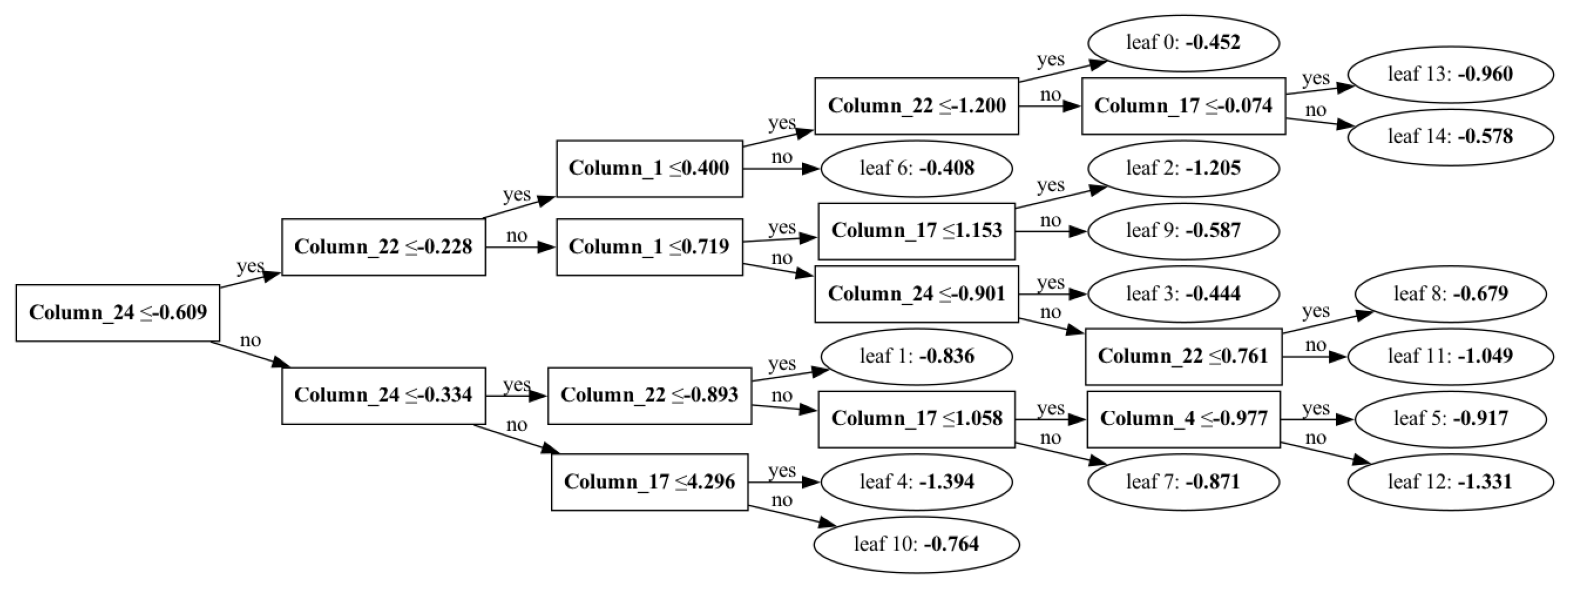

In [38]:
model = best_model.named_steps['classifier']

fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(model, tree_index=0, ax=ax, figsize=(20, 10))
plt.show()

In [42]:
X_dev_transformed = best_model.named_steps['preprocessor'].transform(X_dev)
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

explainer = LimeTabularExplainer(
    X_dev_transformed,
    training_labels=y_dev,
    feature_names=get_feature_names(),
    class_names=["0", "1"],
    mode="classification"
)

instance = X_test_transformed[0].reshape(1, -1) 
explanation = explainer.explain_instance(
    instance.flatten(),
    model.predict_proba  
)

explanation.show_in_notebook(show_table=True)
explanation.save_to_file("lime_explanation_lgbm.html")